## Predicted ionospheric range delay (for different SAR bands and range bandwidths)

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt, ticker
from mintpy.simulation import iono
plt.rcParams.update({'font.size': 12})

work_dir = os.path.expanduser('~/Papers/2022_Geolocation/figs_src/iono')
os.chdir(work_dir)
print('Go to directory:', work_dir)

Go to directory: /Users/yunjunz/Papers/2022_Geolocation/figs_src/iono


In [2]:
# constants
K = 40.31
Re = 6371e3   # earth radius in meters
speed_of_light = 299792458 # speed of light in m / s

# SAR parameters
bnames = ['L', 'S', 'C', 'X']
freqs = [1.257e9, 3.2e9, 5.405e9, 9.65e9]  #carrier frequency for NISAR-L/-S, S1 and TSX
rg_bandwidths = [24e6, 44e6, 80e6]         #range bandwidth (sampling frequency) in Hz
inc_angle = 42                             #LOS incidence angle on the ground in deg
height = 747e3                             #NISAR altitude in meters

inc_angle_iono = iono.incidence_angle_ground2iono(inc_angle)
print('center incidence angle on the ground    : {:.1f} deg'.format(inc_angle))
print('center incidence angle on the ionosphere: {:.1f} deg'.format(inc_angle_iono))

def iono_incidence2refraction_angle(inc_angle, VTEC, freq):
    Ne = VTEC * 1e16
    # equation (26) in Bohm & Schuh (2013) Chapter 2.
    n_iono_group = 1 + K * Ne / freq**2
    ref_angle = np.arcsin(1 / n_iono_group * np.sin(inc_angle * np.pi / 180)) * 180 / np.pi
    return ref_angle

def vtec2range_delay(vtec, inc_angle, freq):
    # convert to TEC in LOS based on equation (3) in Chen and Zebker (2012)
    ref_angle = iono_incidence2refraction_angle(inc_angle, vtec, freq)
    los_tec = vtec / np.cos(ref_angle * np.pi / 180.)
    # calculate range delay based on equation (1) in Chen and Zebker (2012)
    range_delay = (los_tec * 1e16 * K / (freq**2)).astype(np.float32)
    return range_delay

# Numbers for 20 TECU
VTEC = 20

# refraction angle
print('-'*50)
for bname, freq in zip(bnames, freqs):
    ref_angle_iono = iono_incidence2refraction_angle(inc_angle_iono, VTEC, freq)
    rg_delay_inc = (VTEC / np.cos(np.deg2rad(inc_angle_iono)) * 1e16 * K / (freq**2)).astype(np.float32)
    rg_delay_ref = (VTEC / np.cos(np.deg2rad(ref_angle_iono)) * 1e16 * K / (freq**2)).astype(np.float32)
    perc = (rg_delay_inc - rg_delay_ref) / rg_delay_ref * 100
    print(f'20 TECU in {bname}-band --> refraction angle of {ref_angle_iono:3.0f} deg --> {perc:3.0f}% overestimation')


center incidence angle on the ground    : 42.0 deg
center incidence angle on the ionosphere: 38.7 deg
--------------------------------------------------
20 TECU in L-band --> refraction angle of   6 deg -->  27% overestimation
20 TECU in S-band --> refraction angle of  20 deg -->  20% overestimation
20 TECU in C-band --> refraction angle of  29 deg -->  12% overestimation
20 TECU in X-band --> refraction angle of  35 deg -->   5% overestimation


save figure to file /Users/yunjunz/Papers/2021_Geolocation/figs_src/iono/iono_refr_impact.pdf


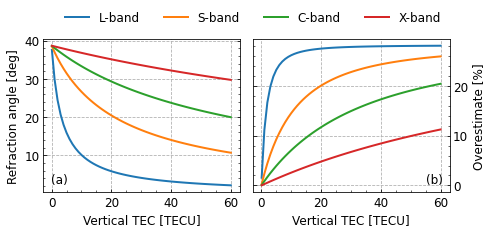

In [22]:
# setup
vtec = np.array([0.1] + np.linspace(1, 60, 60).tolist())  # TECU
inc_angle = 42 # deg
inc_angle_iono = iono.incidence_angle_ground2iono(inc_angle)

# plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[7, 3], sharex=True)
markers = ['-']*4  # ['s-', 'o-', 'd-', '^-']
for i, (bname, freq, marker) in enumerate(zip(bnames, freqs, markers)):
    # calculate
    ref_angle_iono = iono_incidence2refraction_angle(inc_angle_iono, vtec, freq)
    rg_delay_inc = (vtec / np.cos(np.deg2rad(inc_angle_iono)) * 1e16 * K / (freq**2)).astype(np.float32)
    rg_delay_ref = (vtec / np.cos(np.deg2rad(ref_angle_iono)) * 1e16 * K / (freq**2)).astype(np.float32)
    perc = (rg_delay_inc - rg_delay_ref) / rg_delay_ref
    # plot
    axs[0].plot(vtec, ref_angle_iono, marker, lw=2, label=bname+'-band')
    axs[1].plot(vtec, perc * 100.,    marker, lw=2, label=bname+'-band')
# axis format
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
for ax, ystep, num, xloc in zip(axs, [10, 10], ['(a)', '(b)'], [0.04, 0.88]):
    ax.tick_params(which='both', direction='in', left=True, right=True, top=False, bottom=True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(ystep))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.grid('on', linestyle='--')
    ax.set_xlabel('Vertical TEC [TECU]')
    ax.annotate(num, xy=(xloc, 0.06), xycoords='axes fraction')
axs[0].set_ylabel('Refraction angle [deg]')
#axs[1].set_ylabel('Slant range delay\noverestimate [%]')
axs[1].set_ylabel('Overestimate [%]')
fig.tight_layout()

axs[1].legend(ncol=4, handlelength=2, frameon=False, bbox_to_anchor=(1.01, 1.25))

# output
out_fig = os.path.join(work_dir, 'iono_refr_impact.pdf')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()